# First-order posteriors of smooth parameters

__last update__: 02/07/22

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
import numpy as np
import pickle as pkl
import corner
import copy
import seaborn as sns # for nicer colors on the plot

import matplotlib
import matplotlib.pyplot as plt
plt.rc('image', interpolation='none')
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"

from herculens.Parameters.parameters import Parameters
from herculens.Parameters.covariance import FisherCovariance
#from herculens.LightModel.Profiles.sersic_utils import SersicUtil


In [2]:
SAVE_FIGURES = False

In [3]:
# convert names to LaTeX symbols
def fix_labels_latex(names):
    names_fix = copy.deepcopy(names)
    labels_latex = [Parameters.name2latex(name) for name in names]
    # just replace some symbols with a better one
    for l in range(len(labels_latex)):
        if labels_latex[l] == r"$A$":
            labels_latex[l] = "$I_{\\rm Sersic}$"
        elif labels_latex[l] == r"$R_{\rm Sersic}$":
            labels_latex[l] = r"$\theta_{\rm eff}$"
        elif labels_latex[l] == r"$x_0$":
            labels_latex[l] = r"$x_{s}$"
        elif labels_latex[l] == r"$y_0$":
            labels_latex[l] = r"$y_{s}$"
        elif labels_latex[l] == r"$e_1$":
            if l > len(labels_latex)//2:
                labels_latex[l] = r"$e_{1,s}$"
                names_fix[l] = 'e1s'
            else:
                labels_latex[l] = r"$e_{1,\psi}$"
                names_fix[l] = 'e1p'
        elif labels_latex[l] == r"$e_2$":
            if l > len(labels_latex)//2:
                labels_latex[l] = r"$e_{2,s}$"
                names_fix[l] = 'e2s'
            else:
                labels_latex[l] = r"$e_{2,\psi}$"
                names_fix[l] = 'e2p'
    return labels_latex, names_fix

## Relative error plots

In [4]:
mcmc_suffix = '' # '-MCMC'

color_list = sns.color_palette("Set2", 3).as_hex()
colors = {
    "LS": color_list[0],
    "PS": color_list[1],
    "HM": color_list[2],
}
model_choices_relerr = {
    "LS": [
        ("smooth", f'sumplot-real-dark_halo-smooth_potential-smooth_source{mcmc_suffix}.pkl', 'o', False),
        ("pixelated", f'sumplot-real-dark_halo-scale_3-smooth_source{mcmc_suffix}-init_from_smooth.pkl', 's', True),
        ("refined", f'sumplot-real-refined-dark_halo-scale_3-smooth_source{mcmc_suffix}.pkl', 'v', False),
    ],
    "PS": [
        ("smooth", f'sumplot-real-GRF-smooth_potential-smooth_source{mcmc_suffix}.pkl', 'o', False),
        ("pixelated", f'sumplot-real-GRF-scale_3-smooth_source{mcmc_suffix}-init_from_smooth.pkl', 's', True),
        ("high-res", 'sumplot-real-GRF-scale_2-smooth_source-init_from_smooth.pkl', '^', True),
    ],
    "HM": [
        ("smooth", f'sumplot-real-discyness-smooth_potential-smooth_source{mcmc_suffix}.pkl', 'o', False),
        ("pixelated", f'sumplot-real-discyness-scale_3-smooth_source{mcmc_suffix}-init_from_smooth.pkl', 's', True),
        ("refined", f'sumplot-real-refined-discyness-scale_3-smooth_source{mcmc_suffix}.pkl', 'v', False),
    ],
}

In [5]:
def get_data_relerr(filename, hmc_bool=False):
    with open(os.path.join('results', filename), 'rb') as f:
        content = pkl.load(f)
        
        #if content[8] is not None:
        #    fisher_matrix = content[8]
        #    cov_matrix_full = np.linalg.inv(fisher_matrix)
        #    _, cov_matrix = FisherCovariance.split_matrix(cov_matrix_full, 5, 7)
        #else:
        #    cov_matrix = content[10]
        
        cov_matrix = content[10]
           
        truths, mean, names = content[11:14]
        
    if hmc_bool is True:
        hmc_filename = filename.replace('sumplot', 'samples_HMC_n400')
        with open(os.path.join('results', hmc_filename), 'rb') as f:
            content = pkl.load(f)
            samples, logprob, _, _ = content[3]
            num_lens, num_src = 5, 7
            cov_matrix_full = np.cov(samples.T)  # covariance matrix from HMC samples
            _, cov_matrix = FisherCovariance.split_matrix(cov_matrix_full, num_lens, num_src)
            
            #idx_max = int(np.argmax(logprob))
            #lens_value = np.squeeze(samples[idx_max, :num_lens])
            #src_value = np.squeeze(samples[idx_max, -num_src:])
            lens_value = np.median(samples[:, :num_lens], axis=0)
            src_value = np.median(samples[:, -num_src:], axis=0)
            mean = np.concatenate([lens_value, src_value])
            
    if names is not None:
        labels_latex, names_fix = fix_labels_latex(names)
    else:
        labels_latex, names_fix = None, None
    return mean, cov_matrix, truths, names_fix, labels_latex

In [6]:
def relative_error(truth, value, error):
    return (value - truth) / np.abs(truth), error / np.abs(truth), 0

def relative_tension(truth, value, error):
    return (value - truth) / np.abs(error), error / np.abs(error), 0

In [7]:
# select a subset of parameters to display and get their index
displayed_params = ['theta_E', 'e1p', 'e2p', 'gamma1', 'gamma2']

# get their corresponding indices
_, _, truths, names, labels = get_data_relerr('sumplot-real-discyness-scale_3-smooth_source.pkl', hmc_bool=False)  # use some random mdoel
param_indices = [names.index(n) for n in displayed_params]
print(param_indices)

# vector of true values
print(truths, labels)

[0, 1, 2, 3, 4]
[ 1.6   0.15 -0.04 -0.01  0.03 10.    0.8   2.   -0.09  0.03  0.4   0.15] ['$\\theta_{\\rm E}$', '$e_{1,\\psi}$', '$e_{2,\\psi}$', '$\\gamma_{\\rm 1, ext}$', '$\\gamma_{\\rm 2, ext}$', '$I_{\\rm Sersic}$', '$\\theta_{\\rm eff}$', '$n_{\\rm Sersic}$', '$e_{1,s}$', '$e_{2,s}$', '$x_{s}$', '$y_{s}$']


smooth
pixelated
refined
smooth
pixelated
high-res
smooth
pixelated
refined


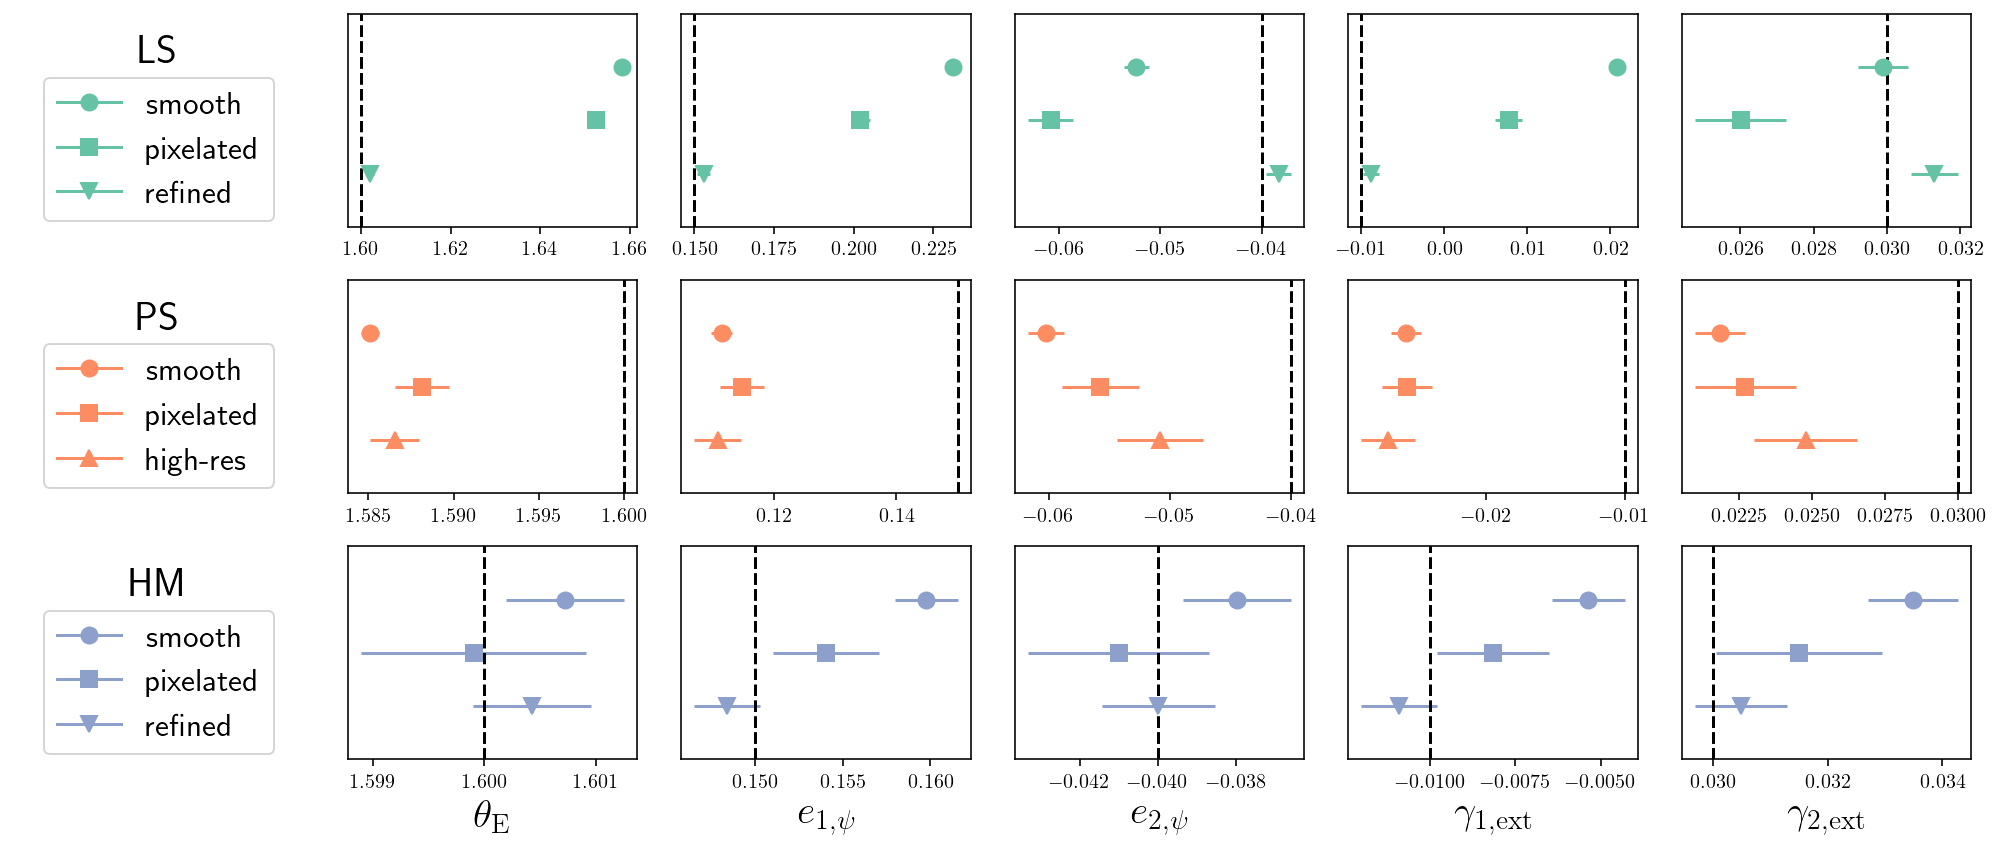

In [9]:
markersize = 8

num_rows, num_cols = len(model_choices_relerr), len(displayed_params)+1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 2*num_rows))

for i, (perturb_type, info_list) in enumerate(model_choices_relerr.items()):
    for j, info in enumerate(info_list):
        model_name = info[0]
        filename = info[1]
        marker = info[2]
        hmc_bool = info[3]
        print(model_name)
        mean, cov, _, _, _ = get_data_relerr(filename, hmc_bool=hmc_bool)
        
        for k, idx in enumerate(param_indices):
            truth = truths[idx]
            value = mean[idx]
            std_dev = np.sqrt(cov[idx, idx])
            
            #val, err, ref = relative_error(truth, value, std_dev)
            #val, err, ref = relative_tension(truth, value, std_dev)
            val, err, ref = value, std_dev, truth
            
            pos = len(info_list) - j - 1  # so it is at a different x position
            ax = axes[i, k+1]
            if i == len(model_choices_relerr)-1:
                ax.set_xlabel(labels[idx], fontsize=20)
            ax.errorbar(val, pos, xerr=err, color=colors[perturb_type], 
                        marker=marker, markersize=markersize, label=model_name)
            ax.axvline(ref, linestyle='--', linewidth=1.5, color='black')
            ax.set_ylim(-1, len(info_list))
            ax.set_yticks([])
            
            #if i == 0 and k == 0:
            #    ax.text(-0.8, 1.602, r"input", color='black', fontsize=14, va='bottom', ha='left')
        
    ax = axes[i, 0]
    ax.axis('off')
    handles, lbls = axes[i, 1].get_legend_handles_labels()
    ax.legend(handles, lbls, fontsize=16,
              bbox_to_anchor=(0.5, -0.05), loc='lower center')
    ax.text(0.5, 0.9, perturb_type, va='top', ha='center',
            transform=ax.transAxes, 
            color='black', fontsize=20)

fig.tight_layout()            
plt.show()

In [10]:
if SAVE_FIGURES:
    figure_dir = os.path.join('figures', 'corner plots')
    figure_name = f'smooth_mass_parameters_recovery.pdf'
    fig.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight')

## Corner plot

### Load samples and parameters info

In [4]:
# Factor of pixel scale for the potential grid
pixel_scale_list = [3]  # will be marginalized over

model_choices = [
    ("LS", 'dark_halo'),
    ("PS", 'GRF'),
    ("HM", 'discyness')
]

full_model_list = []
for (_, pertub_type) in model_choices:
    full_model_list_in = []
    for potential_pixel_scale in pixel_scale_list:
        filename = f'sumplot-real-{pertub_type}-scale_{potential_pixel_scale}-smooth_source-init_from_smooth.pkl'
        full_model_list_in.append(filename)
    full_model_list.append(full_model_list_in)

smooth_model_list = []
for (_, pertub_type) in model_choices:
    filename = [f'sumplot-real-{pertub_type}-smooth_potential-smooth_source.pkl'] # a list to match the above
    smooth_model_list.append(filename)
    
n_smooth = len(smooth_model_list)
n_full = len(full_model_list)
print(n_smooth, n_full)

3 3


In [5]:
def get_data_corner(filename_list, return_truth_idx=None, hmc_bool=False):
    mean_list, cov_list = [], []
    for i, filename_list_in in enumerate(filename_list):
        mean_list_in, cov_list_in = [], []
        for filename in filename_list_in:
            with open(os.path.join('results', filename), 'rb') as f:
                content = pkl.load(f)
                cov_matrix = content[10]
                truths_, mean, names = content[11:14]
                
            if hmc_bool is True:
                hmc_filename = filename.replace('sumplot', 'samples_HMC_n400')
                with open(os.path.join('results', hmc_filename), 'rb') as f:
                    content = pkl.load(f)
                    samples, logprob, _, _ = content[3]
                    num_lens, num_src = 5, 7
                    cov_matrix_full = np.cov(samples.T)  # covariance matrix from HMC samples
                    _, cov_matrix = FisherCovariance.split_matrix(cov_matrix_full, num_lens, num_src)

                    lens_value = np.median(samples[:, :num_lens], axis=0)
                    src_value = np.median(samples[:, -num_src:], axis=0)
                    mean = np.concatenate([lens_value, src_value])
                
            if return_truth_idx is not None and i == return_truth_idx:
                truths = truths_
            elif return_truth_idx is None:
                truths = None
            mean_list_in.append(mean)
            cov_list_in.append(cov_matrix)
        
        
        mean_list.append(np.mean(mean_list_in, axis=0))  # mean of means
        cov_list.append(np.sum(cov_list_in, axis=0))  # sum of covariances ??????
    if names is not None:
        labels_latex, names_fix = fix_labels_latex(names)
    else:
        labels_latex, names_fix = None, None
    return mean_list, cov_list, truths, names_fix, labels_latex

In [6]:
mean_list_full, cov_list_full, truths, names, labels_latex \
    = get_data_corner(full_model_list, return_truth_idx=1, hmc_bool=True)

mean_list_smooth, cov_list_smooth, _, _, _ \
    = get_data_corner(smooth_model_list, return_truth_idx=None)


print(len(mean_list_full[0]), len(mean_list_smooth[0]))
print(truths, len(truths))
assert len(mean_list_full[0]) == len(truths)
assert len(mean_list_full[0]) == len(labels_latex)

12 12
[ 1.6   0.15 -0.04 -0.01  0.03 10.    0.8   2.   -0.09  0.03  0.4   0.15] 12


### Getdist plot

In [7]:
def add_values_indic_to_getdist(g, values, color='green', linewidth=1, linestyle='-', 
                                markersize=10, marker='s', label=None, reverse=False, both_triangles=False):
    # Extract the axes
    ndim = len(values)
    axes = g.subplots #np.array(fig.axes).reshape((ndim, ndim))
    # Loop over the diagonal
    for i in range(ndim):
        if reverse:
            ax = axes[ndim - i - 1, ndim - i - 1]
        else:
            ax = axes[i, i]
        if values[i] is not None:
            ax.axvline(values[i], color=color, linewidth=linewidth, linestyle=linestyle, label=label)
    # Loop over the histograms
    for yi in range(ndim):
        if both_triangles:
            for xi in range(ndim):
                if reverse:
                    ax = axes[ndim - yi - 1, ndim - xi - 1]
                else:
                    ax = axes[yi, xi]
                if values[xi] is not None:
                    ax.axvline(values[xi], color=color, linewidth=linewidth, linestyle=linestyle)
                if values[yi] is not None:
                    ax.axhline(values[yi], color=color, linewidth=linewidth, linestyle=linestyle)
                if values[xi] is not None and values[yi] is not None:
                    ax.plot(values[xi], values[yi], color=color, marker=marker, markersize=markersize)
        else:
            for xi in range(yi):
                if reverse:
                    ax = axes[ndim - yi - 1, ndim - xi - 1]
                else:
                    ax = axes[yi, xi]
                if values[xi] is not None:
                    ax.axvline(values[xi], color=color, linewidth=linewidth, linestyle=linestyle)
                if values[yi] is not None:
                    ax.axhline(values[yi], color=color, linewidth=linewidth, linestyle=linestyle)
                if values[xi] is not None and values[yi] is not None:
                    ax.plot(values[xi], values[yi], color=color, marker=marker, markersize=markersize)

{'theta_E': 1.6, 'e1p': 0.15, 'e2p': -0.04, 'gamma1': -0.01, 'gamma2': 0.03, 'amp': 10.0, 'R_sersic': 0.8, 'n_sersic': 2.0, 'e1s': -0.09, 'e2s': 0.03, 'center_x': 0.4, 'center_y': 0.15}


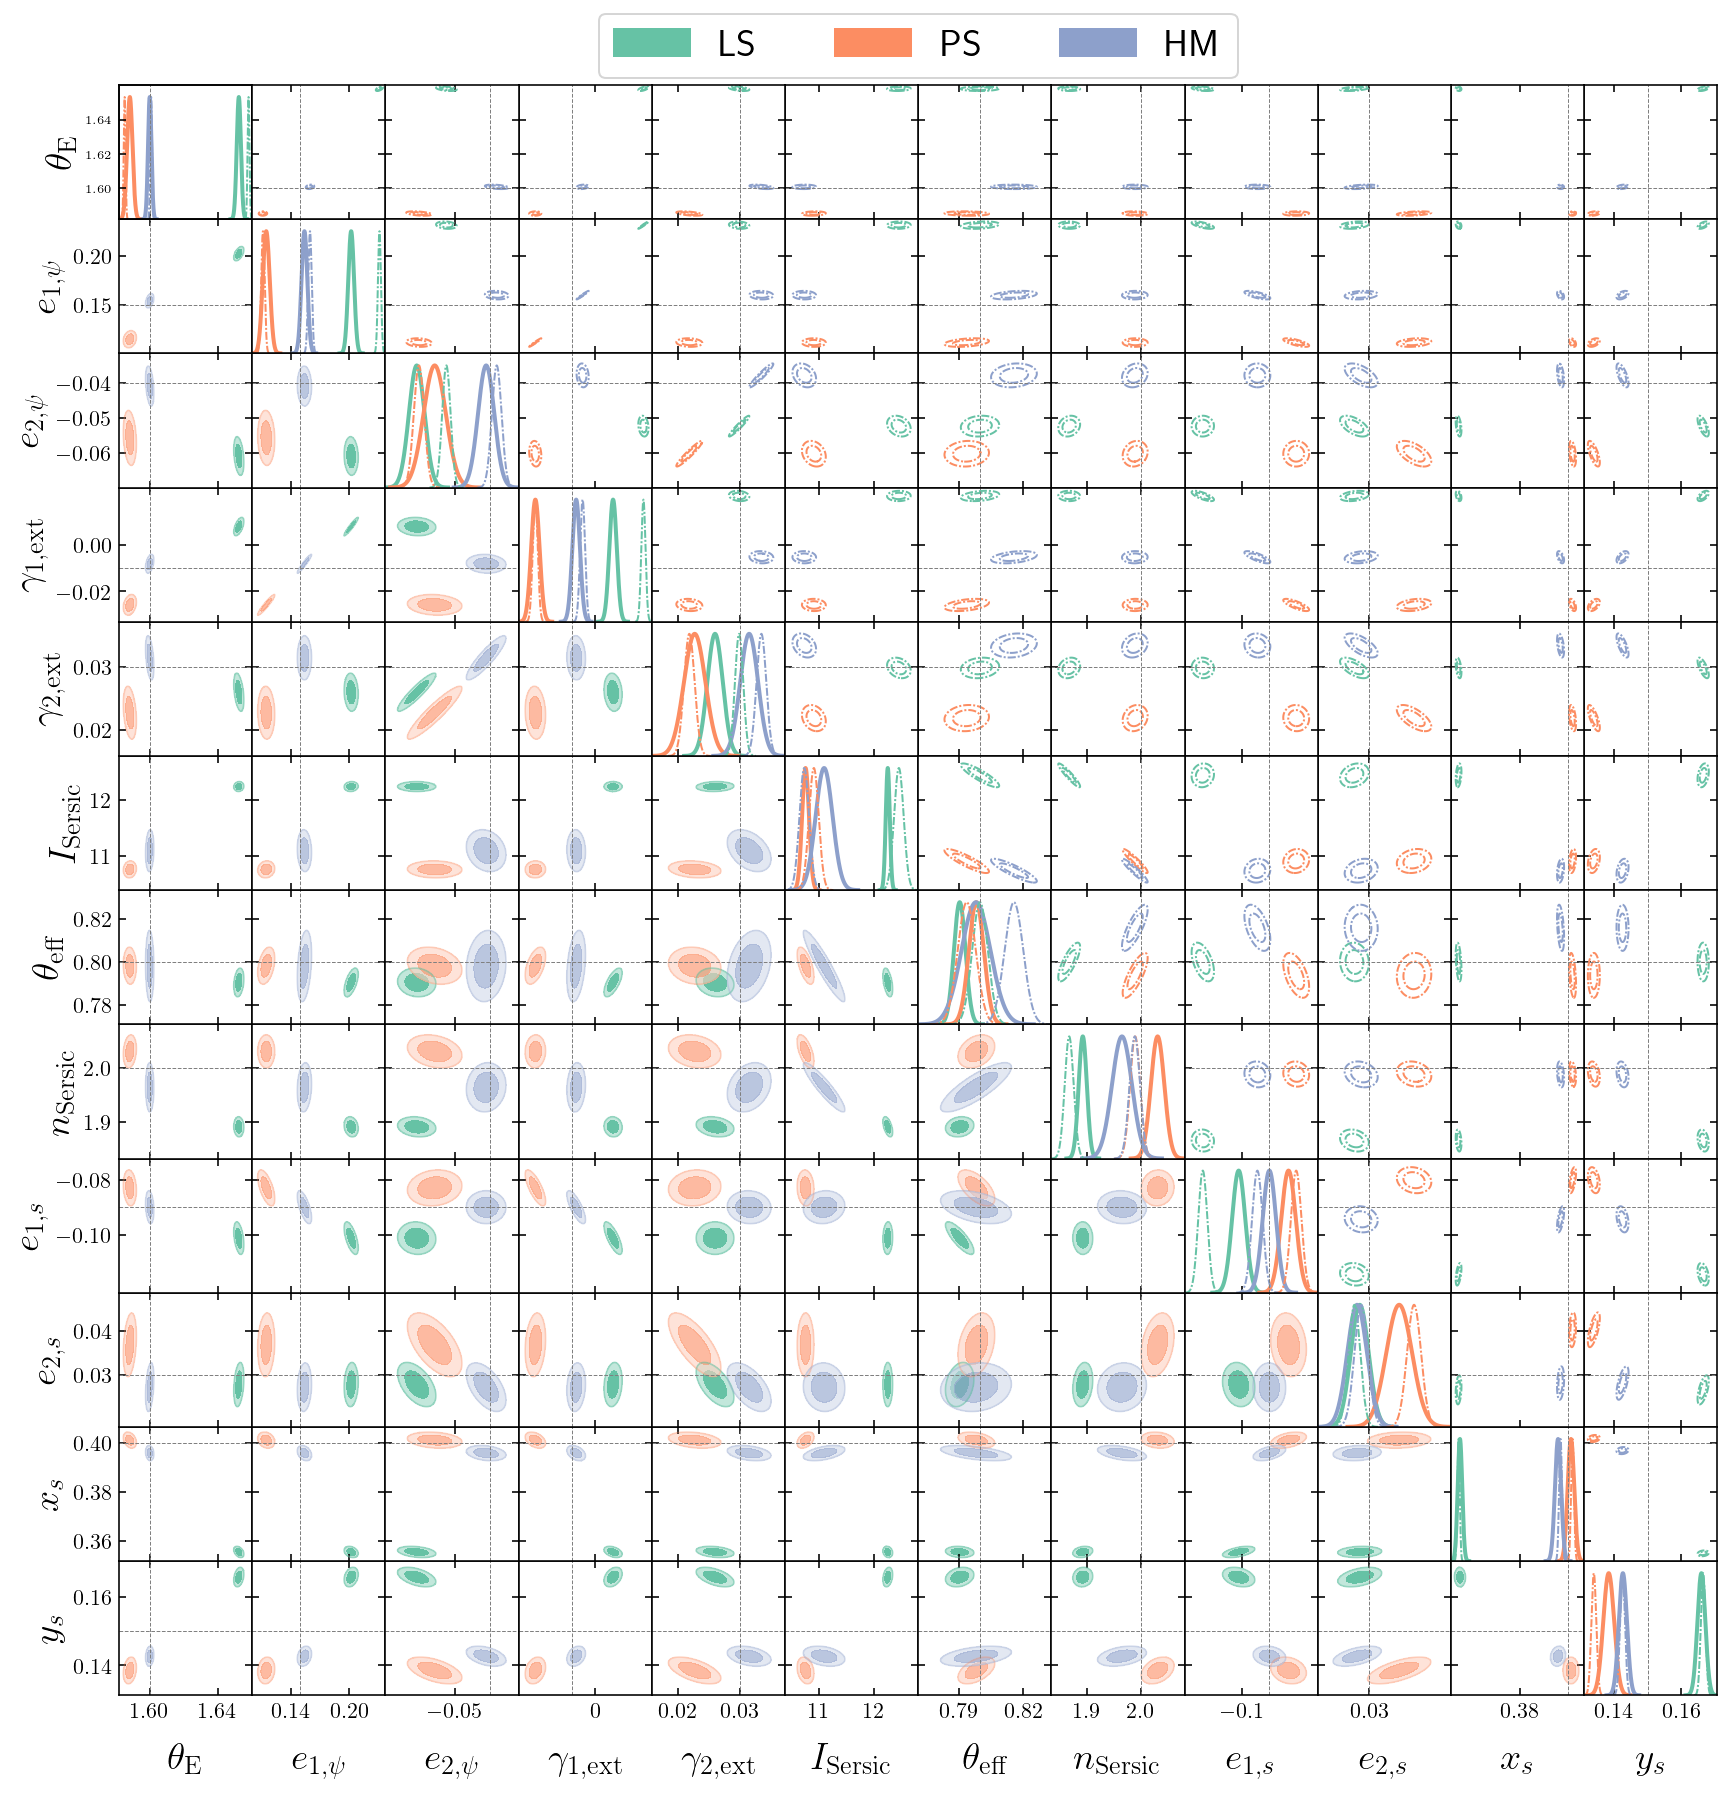

In [9]:
from getdist import plots as gd_plots
from getdist.gaussian_mixtures import GaussianND

color_list = sns.color_palette("Set2", 3).as_hex()# ['tab:blue', 'tab:orange', 'tab:purple']

g = gd_plots.get_subplot_plotter(subplot_size=1)
g.settings.axes_labelsize = 24
g.settings.legend_fontsize = 24
g.settings.axis_tick_max_labels = 5
tick_labelsize = 11
g.settings.alpha_filled_add = 0.6
g.settings.linewidth = 3
g.settings.linewidth_contour = 3
g.settings.progress = False

#smoothing_gd, smoothing_2d_gd = 0.5, 0.5  # std deviation of gaussian kernel (0 < s < 1, if >= 1 is in units of bins)
#settings_smooth = dict(smooth_scale_1D=smoothing_gd, smooth_scale_2D=smoothing_2d_gd)

gauss_list_full = []
gauss_list_smooth = []
for i in range(len(model_choices)):
    gauss_list_full.append(GaussianND(mean_list_full[i], cov_list_full[i], names=names, labels=labels_latex))
    gauss_list_smooth.append(GaussianND(mean_list_smooth[i], cov_list_smooth[i], names=names, labels=labels_latex))


displayed_params = names
#displayed_params = ['theta_E', 'gamma1', 'gamma2', 'R_sersic', 'center_x', 'center_y']
#displayed_params = ['theta_E', 'e1p', 'e2p', 'gamma1', 'gamma2', 'R_sersic']

markers = {n: val for n, val in zip(names, truths)}
print(markers)

upper_kwargs_smooth = {
    'contour_colors': color_list, 
    'contour_ls': ['-.']*n_smooth, 
    'filled': [False]*n_smooth, 
    'show_1d': [True]*n_smooth, 
    'contour_lws': [1]*n_smooth
}
legend_labels = [label for (label, _) in model_choices]

g.triangle_plot(gauss_list_full, 
                displayed_params, 
                legend_labels=legend_labels,
                filled=True,
                colors=color_list, contour_colors=color_list,
                contour_lws=[2]*n_full,
                upper_roots=gauss_list_smooth,
                upper_kwargs=upper_kwargs_smooth,
                markers=markers,
               )

disp_indices = [i for i, name in enumerate(names) if name in displayed_params]
#add_values_indic_to_getdist(g, truths[disp_indices], color='black', markersize=4, linestyle='--',
#                            both_triangles=True)

for ax in g.subplots.flatten():
    ax.tick_params(labelsize=tick_labelsize)
    #if ax is not None:
    #    ax.tick_params(labelsize=tick_labelsize)

In [10]:
if SAVE_FIGURES:
    fig = g.fig
    figure_dir = os.path.join('figures', 'corner plots')
    #figure_name = f'corner_from_fisher_scale{str(pixel_scale_list)}.pdf'
    #fig.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight')
    figure_name = f'corner_from_fisher_scale{str(pixel_scale_list)}.png'
    fig.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight', dpi=200)

## Corner plot